# NOISY ORIGINAL DOMAIN PROJECTION FROM SEVERAL PRINCIPAL COMPONENTS TRANSFORMATION
## Colab set-up


In [ ]:
# Mount Google Drive
from google.colab import drive 

ROOT = "/content/drive"   
print(ROOT)                 

drive.mount(ROOT)           

import os
folder_path = --- # FILL
os.chdir(folder_path)

## Imports


In [ ]:
# Import of the custom modules
import imp 
models_pytorch = imp.new_module('models_pytorch')
exec(open("./models_pytorch.py").read(), models_pytorch.__dict__)

In [ ]:
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
import data_transformer as dt

from models_pytorch import ExtendedMultiLR, ExtendedMLP, ExtendedLenet5
from transformers import IdTransformer, NoisyPcaTransformer
from os.path import join  
from torch import nn
from torch import optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [ ]:
def eval_model_performance(model, trainloader, validloader, testloader):

    train_performance = model.eval_performance(trainloader)
    validation_performance = model.eval_performance(validloader)
    test_performance = model.eval_performance(testloader)

    print("Train Accuracy %.3f" % (round(train_performance.item(), 3)))
    print("Validation Accuracy %.3f" %(round(validation_performance.item(), 3)))
    print("Test Accuracy %.3f" %(round(test_performance.item(), 3)))

    plt.plot(model.loss_during_training, '-b', 
            label='Training Cross Entropy Loss')
    plt.plot(model.valid_loss_during_training, '-r', 
            label='Validation Cross Entropy Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()

## Original MNIST evaluation

In [ ]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, 
                          transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, 
                         transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Splitting training dataset into train and validation
last_train_index = int(len(trainloader.dataset.data) * 0.8)

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

trainloader.dataset.data = trainloader.dataset.data[:last_train_index,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:last_train_index]

validloader.dataset.data = validloader.dataset.data[last_train_index:,:,:]
validloader.dataset.targets = validloader.dataset.targets[last_train_index:]

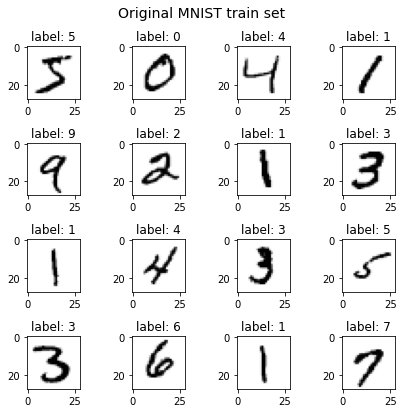

In [ ]:
# Create iterable of train loader and load a chunk
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Plots several example in a grid nrows*ncols
nrows = 4
ncols = 4
num_samples_drawn = int(nrows * ncols)

fig, ax = plt.subplots(nrows, ncols, figsize=(6, 6))

i = 0
for row in range(nrows):
    for col in range(ncols):
        img = images[i].numpy().reshape([28,28])  
        ax[row][col].imshow(img, cmap="Greys")
        fig.show()
        ax[row][col].set_title("label: {}".format(labels[i]))
        i += 1
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # fix for suptitle 
plt.suptitle("Original MNIST train set", fontsize=14)
plt.show()

### Multi LR

In [ ]:
clean_multi_lr = ExtendedMultiLR(dimx=784, nlabels=10, epochs=10, lr=1e-3)
print(clean_multi_lr)
clean_multi_lr.trainloop(trainloader,validloader)

ExtendedMultiLR(
  (output): Linear(in_features=784, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
  (criterion): NLLLoss()
)
Epoch 0. Training loss: 0.513050, Validation loss: 0.338224, Time per epoch: 13.293283 seconds
Epoch 1. Training loss: 0.349234, Validation loss: 0.309960, Time per epoch: 13.350384 seconds
Epoch 2. Training loss: 0.329156, Validation loss: 0.300873, Time per epoch: 13.507808 seconds
Epoch 3. Training loss: 0.319012, Validation loss: 0.296542, Time per epoch: 13.342219 seconds
Epoch 4. Training loss: 0.312322, Validation loss: 0.294034, Time per epoch: 13.384692 seconds
Epoch 5. Training loss: 0.307328, Validation loss: 0.292408, Time per epoch: 13.478025 seconds
Epoch 6. Training loss: 0.303348, Validation loss: 0.291282, Time per epoch: 13.393584 seconds
Epoch 7. Training loss: 0.300047, Validation loss: 0.290480, Time per epoch: 13.341871 seconds
Epoch 8. Training loss: 0.297237, Validation loss: 0.289905, Time per epoch: 13.361352 seconds
Epoch 9.

### MLP

In [ ]:
clean_mlp = ExtendedMLP(dimx=784, hidden1=256, hidden2=128, hidden3=64,
                        nlabels=10, epochs=30, lr=1e-3)
print(clean_mlp)
clean_mlp.trainloop(trainloader, validloader)

ExtendedMLP(
  (output1): Linear(in_features=784, out_features=256, bias=True)
  (output2): Linear(in_features=256, out_features=128, bias=True)
  (output3): Linear(in_features=128, out_features=64, bias=True)
  (output4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)
Epoch 0. Training loss: 0.556604, Validation loss: 0.241634, Time per epoch: 15.693621 seconds
Epoch 1. Training loss: 0.270890, Validation loss: 0.176455, Time per epoch: 15.024259 seconds
Epoch 2. Training loss: 0.217669, Validation loss: 0.160454, Time per epoch: 15.063763 seconds
Epoch 3. Training loss: 0.182306, Validation loss: 0.132875, Time per epoch: 15.076350 seconds
Epoch 4. Training loss: 0.168713, Validation loss: 0.137160, Time per epoch: 14.991412 seconds
Epoch 5. Training loss: 0.151168, Validation loss: 0.116736, Time per epoch: 14.849487 seconds
Epoch 6. Training loss: 0.141533, Valida

### Lenet5

In [ ]:
clean_lenet5 = ExtendedLenet5(dimx=28, nlabels=10, epochs=10, use_batch_norm=True)
print(clean_lenet5)
clean_lenet5.trainloop(trainloader,validloader)

ExtendedLenet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (output1): Linear(in_features=256, out_features=120, bias=True)
  (output2): Linear(in_features=120, out_features=84, bias=True)
  (output3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.4, inplace=False)
  (batch_norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (criterion): NLLLoss()
)
Epoch 0. Training loss: 0.377798, Validation loss: 0.079049, Time per epoch: 17.373037 seconds
Epoch 1. Training loss: 0.117441, Validation loss: 0.067517, Time per epoch: 17.565309 seconds
Epoch 2. Training loss: 0.092291, Validation loss: 0.052835, Time per epoch: 17.671090

In [ ]:
class CustomDataset(Dataset):
    """Pytorch dataset extension.

    This module allows to transform a set of data and targets numpy variables 
    into a pytorch dataset.
    """
    def __init__(self, data, targets, transform=None):
        self.data = data.astype(np.float32)
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

## Transformed MNIST evaluation
Half of the instances have been transformed. The instances have been projected to a lower feature space given by 5 PCA components. Then, instances in that reduced feature space are projected back to the original space. Finally, gaussian noise is added.





In [ ]:
TRANSFORMED_DATA_PATH = join(GIT_REPOSITORY_PATH, 
                             "exp1/output_data_transformer/")

# Loading the data
x_train = np.load(join(TRANSFORMED_DATA_PATH, "mnist_x_train_tr_noisy_proj_pca.npy"))
y_train = np.load(join(TRANSFORMED_DATA_PATH, "mnist_y_train_tr_noisy_proj_pca.npy"))

x_test = np.load(join(TRANSFORMED_DATA_PATH, "mnist_x_test_tr_noisy_proj_pca.npy"))
y_test = np.load(join(TRANSFORMED_DATA_PATH, "mnist_y_test_tr_noisy_proj_pca.npy"))

# Need to be reshaped
x_train = x_train.reshape(60000, 1, 28, 28)
x_test = x_test.reshape(10000, 1, 28, 28)

# Transform into pytorch datasets
trainset = CustomDataset(x_train, y_train, transform=None)
testset = CustomDataset(x_test, y_test, transform=None)

# Transform into pytorch loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Splitting training dataset into train and validation
last_train_index = int(len(trainloader.dataset.data) * 0.8)

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

trainloader.dataset.data = trainloader.dataset.data[:last_train_index,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:last_train_index]

validloader.dataset.data = validloader.dataset.data[last_train_index:,:,:]
validloader.dataset.targets = validloader.dataset.targets[last_train_index:]

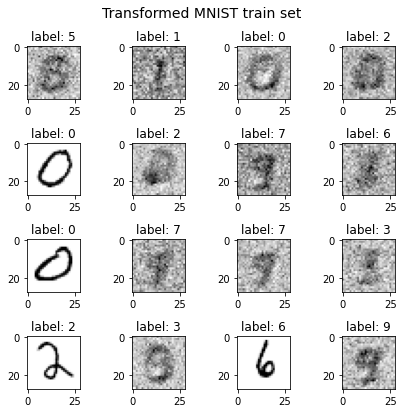

In [ ]:
# Create iterable of train loader and load a chunk
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Plots several example in a grid nrows*ncols
nrows = 4
ncols = 4
num_samples_drawn = int(nrows * ncols)

fig, ax = plt.subplots(nrows, ncols, figsize=(6, 6))

i = 0
for row in range(nrows):
    for col in range(ncols):
        img = images[i].numpy().reshape([28,28])
        ax[row][col].imshow(img, cmap="Greys")
        fig.show()
        ax[row][col].set_title("label: {}".format(labels[i]))
        i += 1
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # fix for suptitle 
plt.suptitle("Transformed MNIST train set", fontsize=14)
plt.show()

### Testing performance of clean models
#### Multi LR

Train Accuracy 0.734
Validation Accuracy 0.730
Test Accuracy 0.738


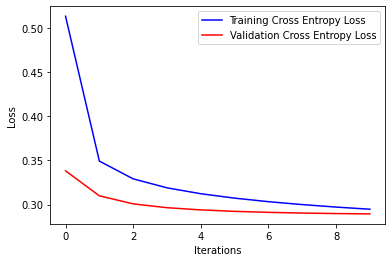

In [ ]:
eval_model_performance(clean_multi_lr, trainloader, validloader, testloader)

#### MLP 

Train Accuracy 0.748
Validation Accuracy 0.750
Test Accuracy 0.744


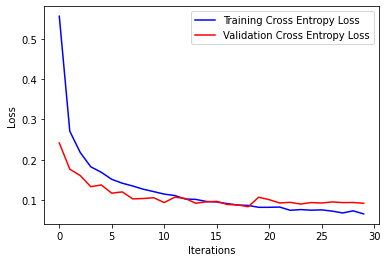

In [ ]:
eval_model_performance(clean_mlp, trainloader, validloader, testloader)

#### Lenet-5

Train Accuracy 0.674
Validation Accuracy 0.676
Test Accuracy 0.672


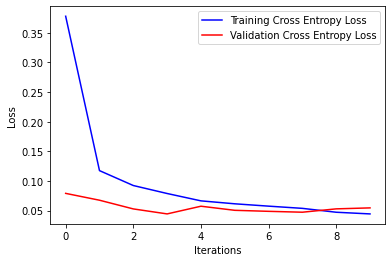

In [ ]:
eval_model_performance(clean_lenet5, trainloader, validloader, testloader)

### Multi LR

In [ ]:
transf_multi_lr = ExtendedMultiLR(dimx=784, nlabels=10, epochs=10, lr=1e-3)
print(transf_multi_lr)

ExtendedMultiLR(
  (output): Linear(in_features=784, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
  (criterion): NLLLoss()
)


In [ ]:
transf_multi_lr.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.825365, Validation loss: 0.719585, Time per epoch: 1.914651 seconds
Epoch 1. Training loss: 0.689948, Validation loss: 0.720186, Time per epoch: 1.918122 seconds
Epoch 2. Training loss: 0.669707, Validation loss: 0.706160, Time per epoch: 1.860661 seconds
Epoch 3. Training loss: 0.659482, Validation loss: 0.722147, Time per epoch: 1.921002 seconds
Epoch 4. Training loss: 0.655049, Validation loss: 0.710746, Time per epoch: 1.787051 seconds
Epoch 5. Training loss: 0.647083, Validation loss: 0.720082, Time per epoch: 1.799611 seconds
Epoch 6. Training loss: 0.640598, Validation loss: 0.740941, Time per epoch: 1.819787 seconds
Epoch 7. Training loss: 0.639003, Validation loss: 0.744917, Time per epoch: 1.777993 seconds
Epoch 8. Training loss: 0.637049, Validation loss: 0.747341, Time per epoch: 1.792167 seconds
Epoch 9. Training loss: 0.635839, Validation loss: 0.749350, Time per epoch: 1.774422 seconds


Train Accuracy 0.788
Validation Accuracy 0.752
Test Accuracy 0.755


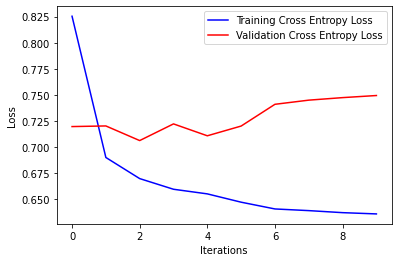

In [ ]:
eval_model_performance(transf_multi_lr, trainloader, validloader, testloader)

### MLP

In [ ]:
transf_mlp = ExtendedMLP(dimx=784, hidden1=256, hidden2=128, hidden3=64,
                  nlabels=10, epochs=30, lr=1e-3)
print(transf_mlp)

ExtendedMLP(
  (output1): Linear(in_features=784, out_features=256, bias=True)
  (output2): Linear(in_features=256, out_features=128, bias=True)
  (output3): Linear(in_features=128, out_features=64, bias=True)
  (output4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)


In [ ]:
transf_mlp.trainloop(trainloader, validloader)

Epoch 0. Training loss: 0.877221, Validation loss: 0.611226, Time per epoch: 3.612875 seconds
Epoch 1. Training loss: 0.629297, Validation loss: 0.579139, Time per epoch: 3.595629 seconds
Epoch 2. Training loss: 0.577569, Validation loss: 0.525616, Time per epoch: 3.697838 seconds
Epoch 3. Training loss: 0.542920, Validation loss: 0.524628, Time per epoch: 3.773313 seconds
Epoch 4. Training loss: 0.517891, Validation loss: 0.515995, Time per epoch: 3.681880 seconds
Epoch 5. Training loss: 0.497970, Validation loss: 0.518846, Time per epoch: 3.608562 seconds
Epoch 6. Training loss: 0.480735, Validation loss: 0.497511, Time per epoch: 3.652313 seconds
Epoch 7. Training loss: 0.464849, Validation loss: 0.508129, Time per epoch: 3.630814 seconds
Epoch 8. Training loss: 0.453281, Validation loss: 0.493213, Time per epoch: 3.685247 seconds
Epoch 9. Training loss: 0.443846, Validation loss: 0.485574, Time per epoch: 3.678355 seconds
Epoch 10. Training loss: 0.430950, Validation loss: 0.496612

Train Accuracy 0.937
Validation Accuracy 0.820
Test Accuracy 0.826


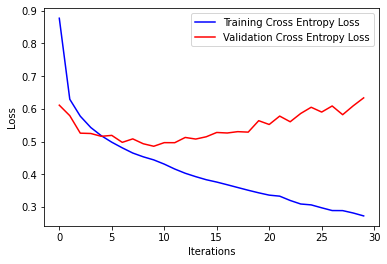

In [ ]:
eval_model_performance(transf_mlp, trainloader, validloader, testloader)

### Lenet5

In [ ]:
transf_lenet5 = ExtendedLenet5(dimx=28, nlabels=10, epochs=10, use_batch_norm=True)
print(transf_lenet5)

ExtendedLenet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (output1): Linear(in_features=256, out_features=120, bias=True)
  (output2): Linear(in_features=120, out_features=84, bias=True)
  (output3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.4, inplace=False)
  (batch_norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (criterion): NLLLoss()
)


In [ ]:
transf_lenet5.trainloop(trainloader, validloader)

Epoch 0. Training loss: 0.800997, Validation loss: 0.504520, Time per epoch: 5.587451 seconds
Epoch 1. Training loss: 0.562130, Validation loss: 0.469500, Time per epoch: 5.478783 seconds
Epoch 2. Training loss: 0.522515, Validation loss: 0.479275, Time per epoch: 5.421273 seconds
Epoch 3. Training loss: 0.499546, Validation loss: 0.449688, Time per epoch: 5.517871 seconds
Epoch 4. Training loss: 0.486212, Validation loss: 0.441686, Time per epoch: 5.536922 seconds
Epoch 5. Training loss: 0.479372, Validation loss: 0.444471, Time per epoch: 5.555996 seconds
Epoch 6. Training loss: 0.469676, Validation loss: 0.430667, Time per epoch: 5.504152 seconds
Epoch 7. Training loss: 0.463211, Validation loss: 0.433136, Time per epoch: 5.583836 seconds
Epoch 8. Training loss: 0.455192, Validation loss: 0.440448, Time per epoch: 5.549808 seconds
Epoch 9. Training loss: 0.447963, Validation loss: 0.425646, Time per epoch: 5.589396 seconds


Train Accuracy 0.858
Validation Accuracy 0.843
Test Accuracy 0.849


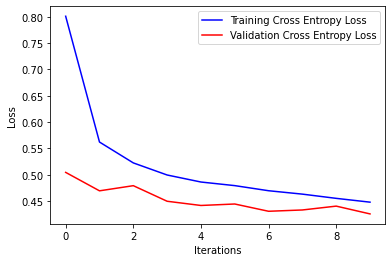

In [ ]:
eval_model_performance(transf_lenet5, trainloader, validloader, testloader)

## Aligned MNIST evaluation
The images which were transformed have been domain aligned back to their original domain with CycleGAN.



In [ ]:
ALIGNED_DATA_PATH = join(GIT_REPOSITORY_PATH, 
                             "exp1/output_gan_image_loader/")

# Loading the data
x_train = np.load(join(ALIGNED_DATA_PATH, "mnist_x_train_aligned_proj_pca.npy"))
y_train = np.load(join(ALIGNED_DATA_PATH, "mnist_y_train_aligned_proj_pca.npy"))

x_test = np.load(join(ALIGNED_DATA_PATH, "mnist_x_test_aligned_proj_pca.npy"))
y_test = np.load(join(ALIGNED_DATA_PATH, "mnist_y_test_aligned_proj_pca.npy"))

# Transform into pytorch datasets
trainset = CustomDataset(x_train, y_train, transform=transform)
testset = CustomDataset(x_test, y_test, transform=transform)

# Transform into pytorch loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Splitting training dataset into train and validation
last_train_index = int(len(trainloader.dataset.data) * 0.8)

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

trainloader.dataset.data = trainloader.dataset.data[:last_train_index,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:last_train_index]

validloader.dataset.data = validloader.dataset.data[last_train_index:,:,:]
validloader.dataset.targets = validloader.dataset.targets[last_train_index:]

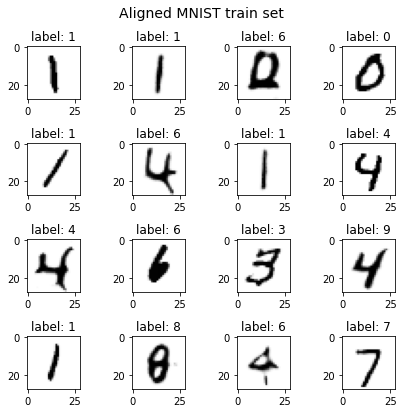

In [ ]:
# Create iterable of train loader and load a chunk
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Plots several example in a grid nrows*ncols
nrows = 4
ncols = 4
num_samples_drawn = int(nrows * ncols)

fig, ax = plt.subplots(nrows, ncols, figsize=(6, 6))

i = 0
for row in range(nrows):
    for col in range(ncols):
        img = images[i].numpy().reshape([28,28])  
        ax[row][col].imshow(img, cmap="Greys")
        fig.show()
        ax[row][col].set_title("label: {}".format(labels[i]))
        i += 1
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) # fix for suptitle 
plt.suptitle("Aligned MNIST train set", fontsize=14)
plt.show()

### Testing performance of clean models
#### Multi LR

Train Accuracy 0.760
Validation Accuracy 0.768
Test Accuracy 0.765


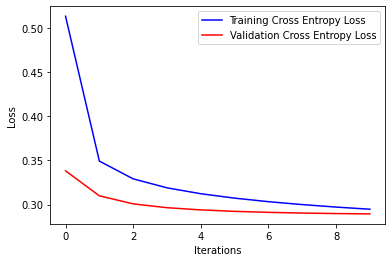

In [ ]:
eval_model_performance(clean_multi_lr, trainloader, validloader, testloader)

#### MLP

Train Accuracy 0.799
Validation Accuracy 0.801
Test Accuracy 0.795


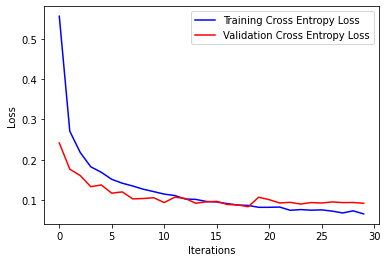

In [ ]:
eval_model_performance(clean_mlp, trainloader, validloader, testloader)

#### Lenet5

Train Accuracy 0.792
Validation Accuracy 0.794
Test Accuracy 0.795


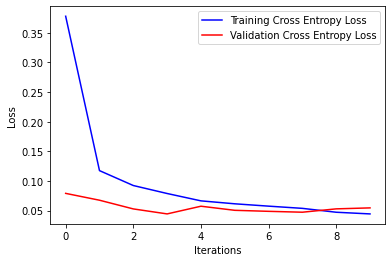

In [ ]:
eval_model_performance(clean_lenet5, trainloader, validloader, testloader)

### Multi LR

In [ ]:
aligned_multi_lr = ExtendedMultiLR(dimx=784, nlabels=10, epochs=10, lr=1e-3)
print(aligned_multi_lr)

ExtendedMultiLR(
  (output): Linear(in_features=784, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
  (criterion): NLLLoss()
)


In [ ]:
aligned_multi_lr.trainloop(trainloader,validloader)

Epoch 0. Training loss: 0.823691, Validation loss: 0.720840, Time per epoch: 13.508115 seconds
Epoch 1. Training loss: 0.706678, Validation loss: 0.698229, Time per epoch: 13.401198 seconds
Epoch 2. Training loss: 0.687364, Validation loss: 0.683403, Time per epoch: 13.624669 seconds
Epoch 3. Training loss: 0.676692, Validation loss: 0.680836, Time per epoch: 13.551321 seconds
Epoch 4. Training loss: 0.670882, Validation loss: 0.665240, Time per epoch: 13.482461 seconds
Epoch 5. Training loss: 0.664077, Validation loss: 0.656444, Time per epoch: 13.528043 seconds
Epoch 6. Training loss: 0.659303, Validation loss: 0.655635, Time per epoch: 13.396628 seconds
Epoch 7. Training loss: 0.655667, Validation loss: 0.688681, Time per epoch: 13.442539 seconds
Epoch 8. Training loss: 0.653542, Validation loss: 0.692570, Time per epoch: 13.513202 seconds
Epoch 9. Training loss: 0.652781, Validation loss: 0.667737, Time per epoch: 13.513875 seconds


Train Accuracy 0.790
Validation Accuracy 0.783
Test Accuracy 0.791


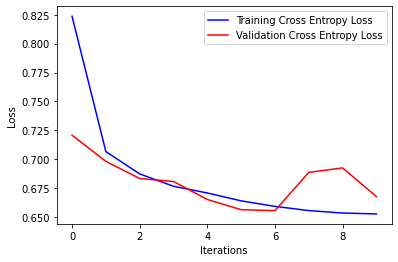

In [ ]:
eval_model_performance(aligned_multi_lr, trainloader, validloader, testloader)

### MLP

In [ ]:
aligned_mlp = ExtendedMLP(dimx=784, hidden1=256, hidden2=128, hidden3=64,
                  nlabels=10, epochs=30, lr=1e-3)
print(aligned_mlp)

ExtendedMLP(
  (output1): Linear(in_features=784, out_features=256, bias=True)
  (output2): Linear(in_features=256, out_features=128, bias=True)
  (output3): Linear(in_features=128, out_features=64, bias=True)
  (output4): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.2, inplace=False)
  (criterion): NLLLoss()
)


In [ ]:
aligned_mlp.trainloop(trainloader, validloader)

Epoch 0. Training loss: 0.864612, Validation loss: 0.605433, Time per epoch: 15.398464 seconds
Epoch 1. Training loss: 0.648932, Validation loss: 0.542391, Time per epoch: 15.494951 seconds
Epoch 2. Training loss: 0.596235, Validation loss: 0.532475, Time per epoch: 15.466735 seconds
Epoch 3. Training loss: 0.568754, Validation loss: 0.517482, Time per epoch: 15.589032 seconds
Epoch 4. Training loss: 0.546006, Validation loss: 0.475840, Time per epoch: 15.404607 seconds
Epoch 5. Training loss: 0.532082, Validation loss: 0.472527, Time per epoch: 15.425514 seconds
Epoch 6. Training loss: 0.522135, Validation loss: 0.467136, Time per epoch: 15.388988 seconds
Epoch 7. Training loss: 0.510230, Validation loss: 0.457575, Time per epoch: 15.600782 seconds
Epoch 8. Training loss: 0.498178, Validation loss: 0.460900, Time per epoch: 15.407506 seconds
Epoch 9. Training loss: 0.498311, Validation loss: 0.449620, Time per epoch: 15.383711 seconds
Epoch 10. Training loss: 0.485212, Validation loss

Train Accuracy 0.867
Validation Accuracy 0.849
Test Accuracy 0.852


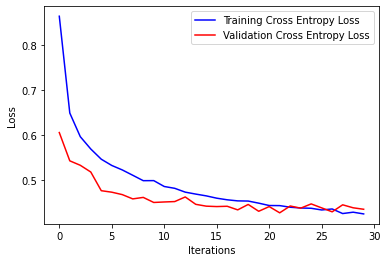

In [ ]:
eval_model_performance(aligned_mlp, trainloader, validloader, testloader)

### Lenet5

In [ ]:
aligned_lenet5 = ExtendedLenet5(dimx=28, nlabels=10, epochs=10, use_batch_norm=True)
print(aligned_lenet5)

ExtendedLenet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (output1): Linear(in_features=256, out_features=120, bias=True)
  (output2): Linear(in_features=120, out_features=84, bias=True)
  (output3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.4, inplace=False)
  (batch_norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (criterion): NLLLoss()
)


In [ ]:
aligned_lenet5.trainloop(trainloader, validloader)

Epoch 0. Training loss: 0.810571, Validation loss: 0.513624, Time per epoch: 17.439288 seconds
Epoch 1. Training loss: 0.576416, Validation loss: 0.467908, Time per epoch: 17.868359 seconds
Epoch 2. Training loss: 0.532502, Validation loss: 0.465169, Time per epoch: 17.721091 seconds
Epoch 3. Training loss: 0.504919, Validation loss: 0.435246, Time per epoch: 17.708704 seconds
Epoch 4. Training loss: 0.487116, Validation loss: 0.422772, Time per epoch: 17.718785 seconds
Epoch 5. Training loss: 0.473935, Validation loss: 0.417739, Time per epoch: 17.888302 seconds
Epoch 6. Training loss: 0.466166, Validation loss: 0.419592, Time per epoch: 17.670351 seconds
Epoch 7. Training loss: 0.456473, Validation loss: 0.416501, Time per epoch: 17.577957 seconds
Epoch 8. Training loss: 0.449502, Validation loss: 0.417093, Time per epoch: 17.512837 seconds
Epoch 9. Training loss: 0.442741, Validation loss: 0.424421, Time per epoch: 17.780826 seconds


Train Accuracy 0.860
Validation Accuracy 0.850
Test Accuracy 0.854


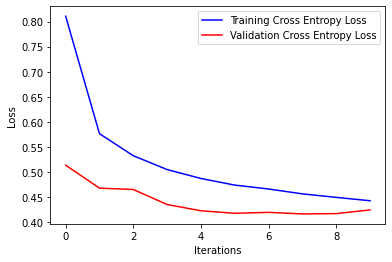

In [ ]:
eval_model_performance(aligned_lenet5, trainloader, validloader, testloader)